# Exercise 7: Customer Behavioral Analysis for Online Purchase Model

## Objectives
- Analyze customer behavior patterns for online purchases
- Build predictive models using logistic regression
- Perform customer segmentation and purchase prediction
- Evaluate model performance with various metrics
- Create interactive prediction system

## Business Context
We'll analyze customer demographics (age, salary) to predict their likelihood of making an online purchase. This type of analysis is crucial for:
- Targeted marketing campaigns
- Customer segmentation
- Sales forecasting
- Resource allocation

## 1. Setup and Data Preparation

In [93]:
# Install dependencies
%pip install -q numpy pandas matplotlib scikit-learn seaborn plotly

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("All libraries imported successfully!")

Note: you may need to restart the kernel to use updated packages.
All libraries imported successfully!


## 2. Data Loading and Generation

In [94]:
# Uncomment the following line to download the dataset from Kaggle
# !curl -sL -o social-network-ads.zip https://www.kaggle.com/api/v1/datasets/download/rakeshrau/social-network-ads && unzip -q social-network-ads.zip && rm social-network-ads.zip

In [95]:
dataset = pd.read_csv('Social_Network_Ads.csv')

# Display the first few rows of the dataset
print(f"Dataset shape: {dataset.shape}")
print("\nFirst 10 rows:")
print(dataset.head(10))
print("\nDataset info:")
print(dataset.info())

Dataset shape: (400, 5)

First 10 rows:
    User ID  Gender  Age  EstimatedSalary  Purchased
0  15624510    Male   19            19000          0
1  15810944    Male   35            20000          0
2  15668575  Female   26            43000          0
3  15603246  Female   27            57000          0
4  15804002    Male   19            76000          0
5  15728773    Male   27            58000          0
6  15598044  Female   27            84000          0
7  15694829  Female   32           150000          1
8  15600575    Male   25            33000          0
9  15727311  Female   35            65000          0

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-nul

In [96]:
# Data overview and statistics
print("Dataset Description:")
print(dataset.describe())

print("\nPurchase Distribution:")
print(dataset['Purchased'].value_counts())
print(f"Purchase Rate: {dataset['Purchased'].mean():.2%}")

print("\nGender Distribution:")
print(dataset['Gender'].value_counts())

Dataset Description:
            User ID         Age  EstimatedSalary   Purchased
count  4.000000e+02  400.000000       400.000000  400.000000
mean   1.569154e+07   37.655000     69742.500000    0.357500
std    7.165832e+04   10.482877     34096.960282    0.479864
min    1.556669e+07   18.000000     15000.000000    0.000000
25%    1.562676e+07   29.750000     43000.000000    0.000000
50%    1.569434e+07   37.000000     70000.000000    0.000000
75%    1.575036e+07   46.000000     88000.000000    1.000000
max    1.581524e+07   60.000000    150000.000000    1.000000

Purchase Distribution:
Purchased
0    257
1    143
Name: count, dtype: int64
Purchase Rate: 35.75%

Gender Distribution:
Gender
Female    204
Male      196
Name: count, dtype: int64


## 3. Exploratory Data Analysis

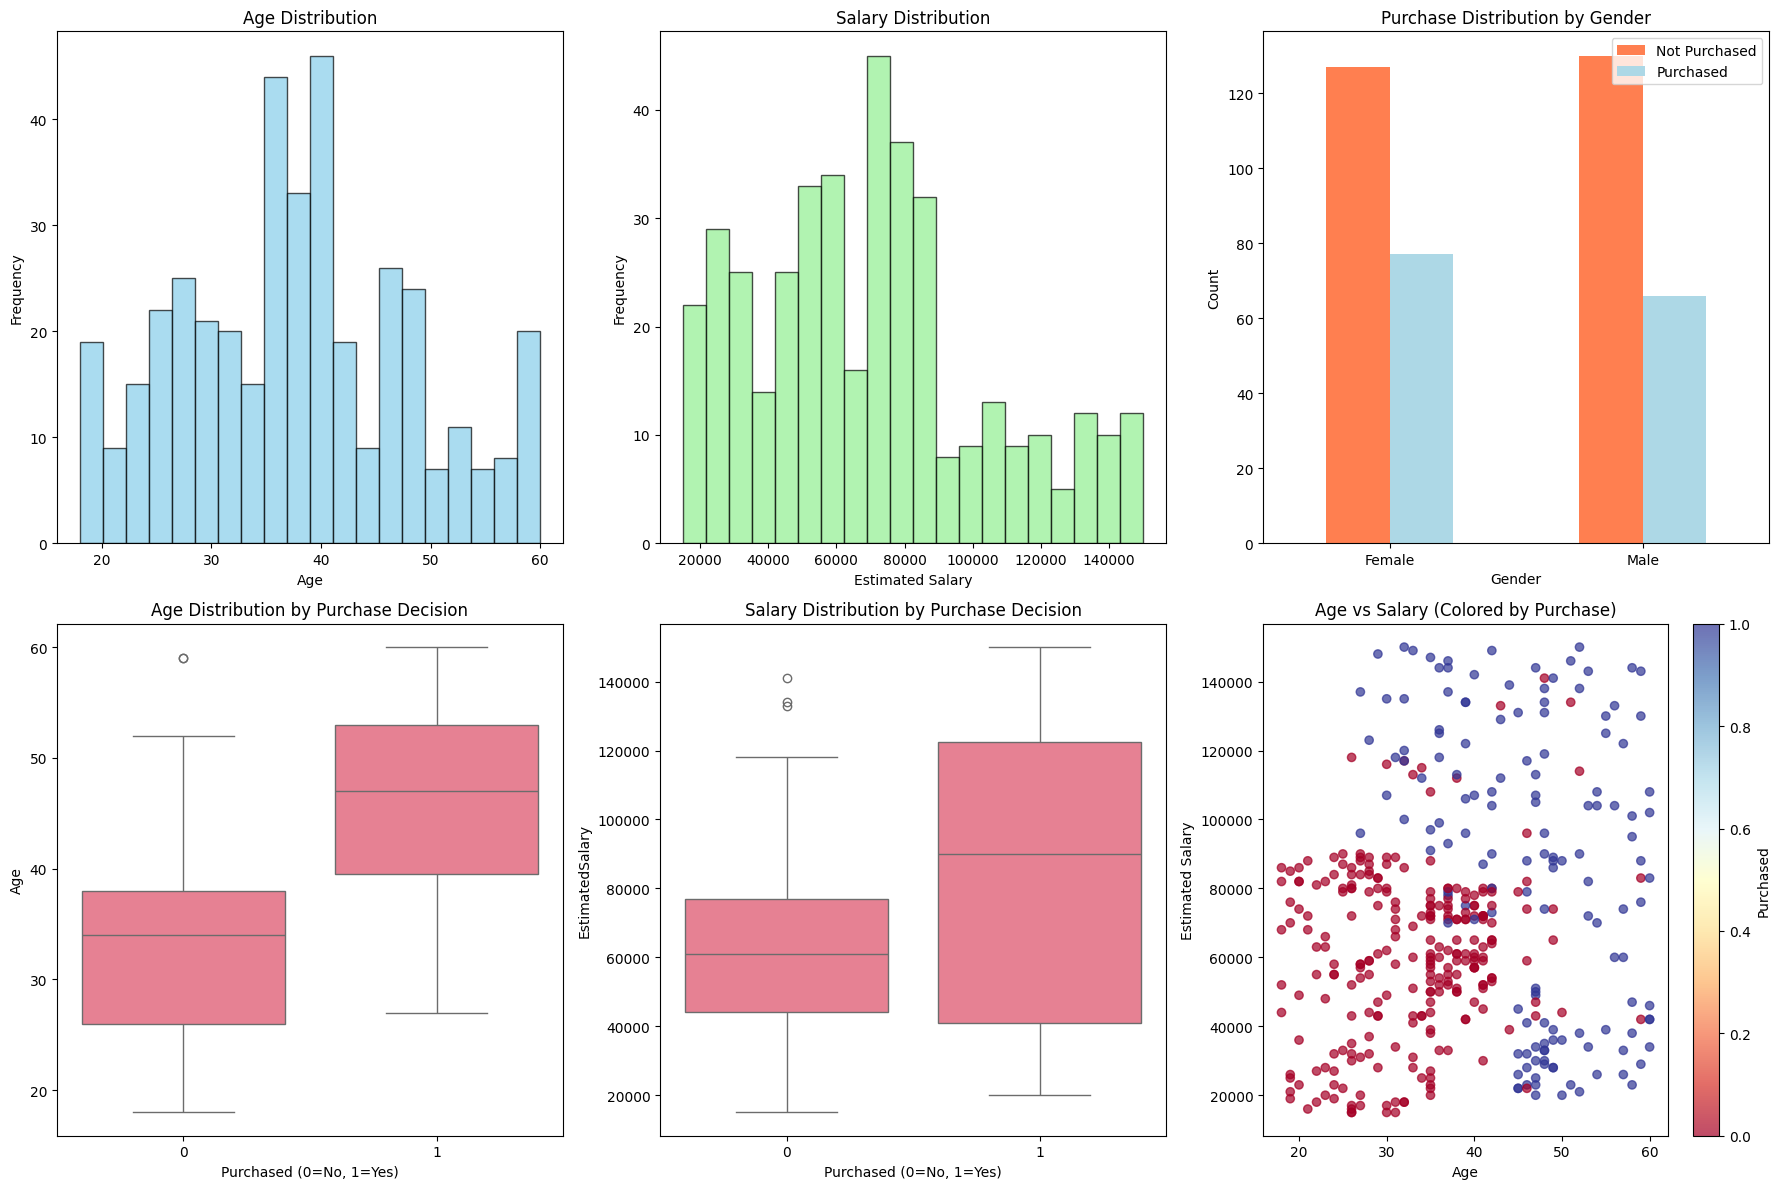

In [97]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Age distribution
axes[0, 0].hist(dataset['Age'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Age Distribution')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')

# Salary distribution
axes[0, 1].hist(dataset['EstimatedSalary'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Salary Distribution')
axes[0, 1].set_xlabel('Estimated Salary')
axes[0, 1].set_ylabel('Frequency')

# Purchase by Gender
purchase_gender = dataset.groupby(['Gender', 'Purchased']).size().unstack()
purchase_gender.plot(kind='bar', ax=axes[0, 2], color=['coral', 'lightblue'])
axes[0, 2].set_title('Purchase Distribution by Gender')
axes[0, 2].set_xlabel('Gender')
axes[0, 2].set_ylabel('Count')
axes[0, 2].legend(['Not Purchased', 'Purchased'])
axes[0, 2].tick_params(axis='x', rotation=0)

# Age vs Purchase
sns.boxplot(data=dataset, x='Purchased', y='Age', ax=axes[1, 0])
axes[1, 0].set_title('Age Distribution by Purchase Decision')
axes[1, 0].set_xlabel('Purchased (0=No, 1=Yes)')

# Salary vs Purchase
sns.boxplot(data=dataset, x='Purchased', y='EstimatedSalary', ax=axes[1, 1])
axes[1, 1].set_title('Salary Distribution by Purchase Decision')
axes[1, 1].set_xlabel('Purchased (0=No, 1=Yes)')

# Scatter plot: Age vs Salary colored by Purchase
scatter = axes[1, 2].scatter(dataset['Age'], dataset['EstimatedSalary'], 
                           c=dataset['Purchased'], cmap='RdYlBu', alpha=0.7)
axes[1, 2].set_title('Age vs Salary (Colored by Purchase)')
axes[1, 2].set_xlabel('Age')
axes[1, 2].set_ylabel('Estimated Salary')
plt.colorbar(scatter, ax=axes[1, 2], label='Purchased')

plt.tight_layout()
plt.show()

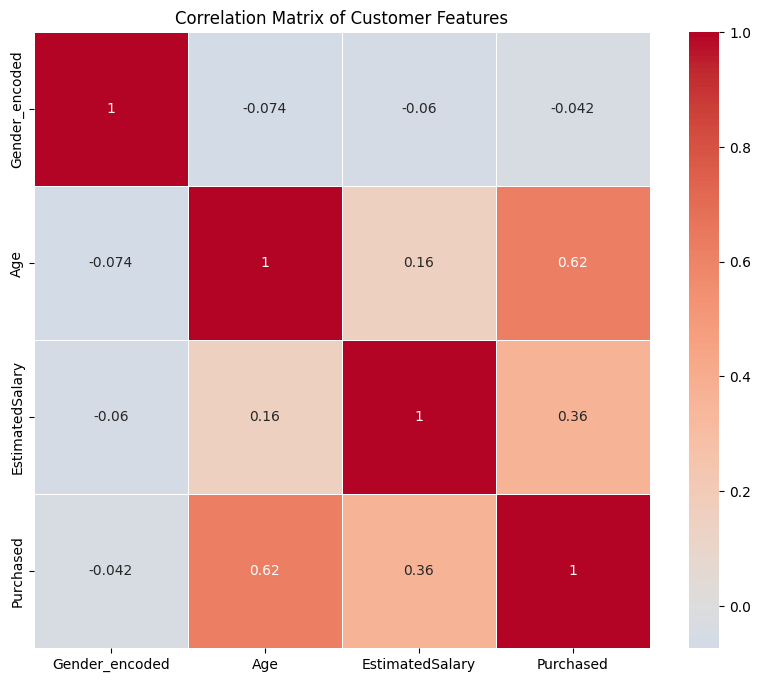

Correlation with Purchase Decision:
Purchased          1.000000
Age                0.622454
EstimatedSalary    0.362083
Gender_encoded    -0.042469
Name: Purchased, dtype: float64


In [98]:
# Correlation analysis
# Encode gender for correlation
dataset_encoded = dataset.copy()
le = LabelEncoder()
dataset_encoded['Gender_encoded'] = le.fit_transform(dataset['Gender'])

# Calculate correlation matrix
corr_matrix = dataset_encoded[['Gender_encoded', 'Age', 'EstimatedSalary', 'Purchased']].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Customer Features')
plt.show()

print("Correlation with Purchase Decision:")
print(corr_matrix['Purchased'].sort_values(ascending=False))

## 4. Data Preprocessing

In [99]:
# Prepare features and target
# Using Age and Estimated Salary as features (following the original code)
X = dataset.iloc[:, [2, 3]].values  # Age and EstimatedSalary
y = dataset.iloc[:, -1].values      # Purchased

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)
print("\nFeature names: ['Age', 'EstimatedSalary']")
print("Target name: 'Purchased'")

# Display first few samples 
print("\nFirst 5 samples:")
for i in range(5):
    print(f"Age: {X[i][0]}, Salary: {X[i][1]}, Purchased: {y[i]}")

Feature matrix shape: (400, 2)
Target vector shape: (400,)

Feature names: ['Age', 'EstimatedSalary']
Target name: 'Purchased'

First 5 samples:
Age: 19, Salary: 19000, Purchased: 0
Age: 35, Salary: 20000, Purchased: 0
Age: 26, Salary: 43000, Purchased: 0
Age: 27, Salary: 57000, Purchased: 0
Age: 19, Salary: 76000, Purchased: 0


In [100]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print("Dataset Split Information:")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Training set percentage: {len(X_train)/len(X)*100:.1f}%")
print(f"Testing set percentage: {len(X_test)/len(X)*100:.1f}%")

print("\nTraining set samples (first 5):")
for i in range(5):
    print(f"Age: {X_train[i][0]:.0f}, Salary: {X_train[i][1]:.0f}, Purchased: {y_train[i]}")

print("\nTesting set samples (first 5):")
for i in range(5):
    print(f"Age: {X_test[i][0]:.0f}, Salary: {X_test[i][1]:.0f}, Purchased: {y_test[i]}")

Dataset Split Information:
Training set size: 300 samples
Testing set size: 100 samples
Training set percentage: 75.0%
Testing set percentage: 25.0%

Training set samples (first 5):
Age: 44, Salary: 39000, Purchased: 0
Age: 32, Salary: 120000, Purchased: 1
Age: 38, Salary: 50000, Purchased: 0
Age: 32, Salary: 135000, Purchased: 1
Age: 52, Salary: 21000, Purchased: 1

Testing set samples (first 5):
Age: 30, Salary: 87000, Purchased: 0
Age: 38, Salary: 50000, Purchased: 0
Age: 35, Salary: 75000, Purchased: 0
Age: 30, Salary: 79000, Purchased: 0
Age: 35, Salary: 50000, Purchased: 0


## 5. Feature Scaling

In [101]:
# Feature scaling using StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

print("Feature Scaling Results:")
print("\nOriginal Training Data (first 5 samples):")
for i in range(5):
    print(f"Age: {X_train[i][0]:.0f}, Salary: {X_train[i][1]:.0f}")

print("\nScaled Training Data (first 5 samples):")
for i in range(5):
    print(f"Age: {X_train_scaled[i][0]:.3f}, Salary: {X_train_scaled[i][1]:.3f}")

print("\nScaling Statistics:")
print(f"Age - Mean: {sc.mean_[0]:.2f}, Std: {sc.scale_[0]:.2f}")
print(f"Salary - Mean: {sc.mean_[1]:.2f}, Std: {sc.scale_[1]:.2f}")

Feature Scaling Results:

Original Training Data (first 5 samples):
Age: 44, Salary: 39000
Age: 32, Salary: 120000
Age: 38, Salary: 50000
Age: 32, Salary: 135000
Age: 52, Salary: 21000

Scaled Training Data (first 5 samples):
Age: 0.582, Salary: -0.887
Age: -0.607, Salary: 1.462
Age: -0.013, Salary: -0.568
Age: -0.607, Salary: 1.897
Age: 1.374, Salary: -1.409

Scaling Statistics:
Age - Mean: 38.13, Std: 10.10
Salary - Mean: 69583.33, Std: 34490.91


## 6. Model Building and Training

In [102]:
# Build and train Logistic Regression model
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train_scaled, y_train)

print("Logistic Regression Model Training Complete!")
print("\nModel Parameters:")
print(f"Intercept: {classifier.intercept_[0]:.4f}")
print(f"Coefficients: Age = {classifier.coef_[0][0]:.4f}, Salary = {classifier.coef_[0][1]:.4f}")

# Model interpretation
print("\nModel Interpretation:")
if classifier.coef_[0][0] > 0:
    print("- Age has a positive effect on purchase probability")
else:
    print("- Age has a negative effect on purchase probability")
    
if classifier.coef_[0][1] > 0:
    print("- Salary has a positive effect on purchase probability")
else:
    print("- Salary has a negative effect on purchase probability")

Logistic Regression Model Training Complete!

Model Parameters:
Intercept: -0.9522
Coefficients: Age = 2.0767, Salary = 1.1101

Model Interpretation:
- Age has a positive effect on purchase probability
- Salary has a positive effect on purchase probability


## 7. Model Prediction and Evaluation

In [103]:
# Make predictions on test set
y_pred = classifier.predict(X_test_scaled)
y_pred_proba = classifier.predict_proba(X_test_scaled)[:, 1]

print("Prediction Results:")
print("\nFirst 10 predictions vs actual:")
comparison = np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)), 1)
comparison_df = pd.DataFrame(comparison, columns=['Predicted', 'Actual'])
comparison_df['Correct'] = comparison_df['Predicted'] == comparison_df['Actual']
print(comparison_df.head(10))

print(f"\nCorrect predictions in first 10: {comparison_df['Correct'].head(10).sum()}/10")

Prediction Results:

First 10 predictions vs actual:
   Predicted  Actual  Correct
0          0       0     True
1          0       0     True
2          0       0     True
3          0       0     True
4          0       0     True
5          0       0     True
6          0       0     True
7          1       1     True
8          0       0     True
9          1       0    False

Correct predictions in first 10: 9/10


In [104]:
# Comprehensive model evaluation
print("Model Performance Evaluation:")
print("=" * 40)

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Purchased', 'Purchased']))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Additional metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)  # True Positive Rate
specificity = tn / (tn + fp)  # True Negative Rate
precision = tp / (tp + fp)    # Positive Predictive Value

print(f"\nDetailed Metrics:")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")

Model Performance Evaluation:
Accuracy Score: 0.8900 (89.00%)

Confusion Matrix:
[[65  3]
 [ 8 24]]

Classification Report:
               precision    recall  f1-score   support

Not Purchased       0.89      0.96      0.92        68
    Purchased       0.89      0.75      0.81        32

     accuracy                           0.89       100
    macro avg       0.89      0.85      0.87       100
 weighted avg       0.89      0.89      0.89       100


ROC AUC Score: 0.9540

Detailed Metrics:
Sensitivity (Recall): 0.7500
Specificity: 0.9559
Precision: 0.8889


## 8. Results Visualization

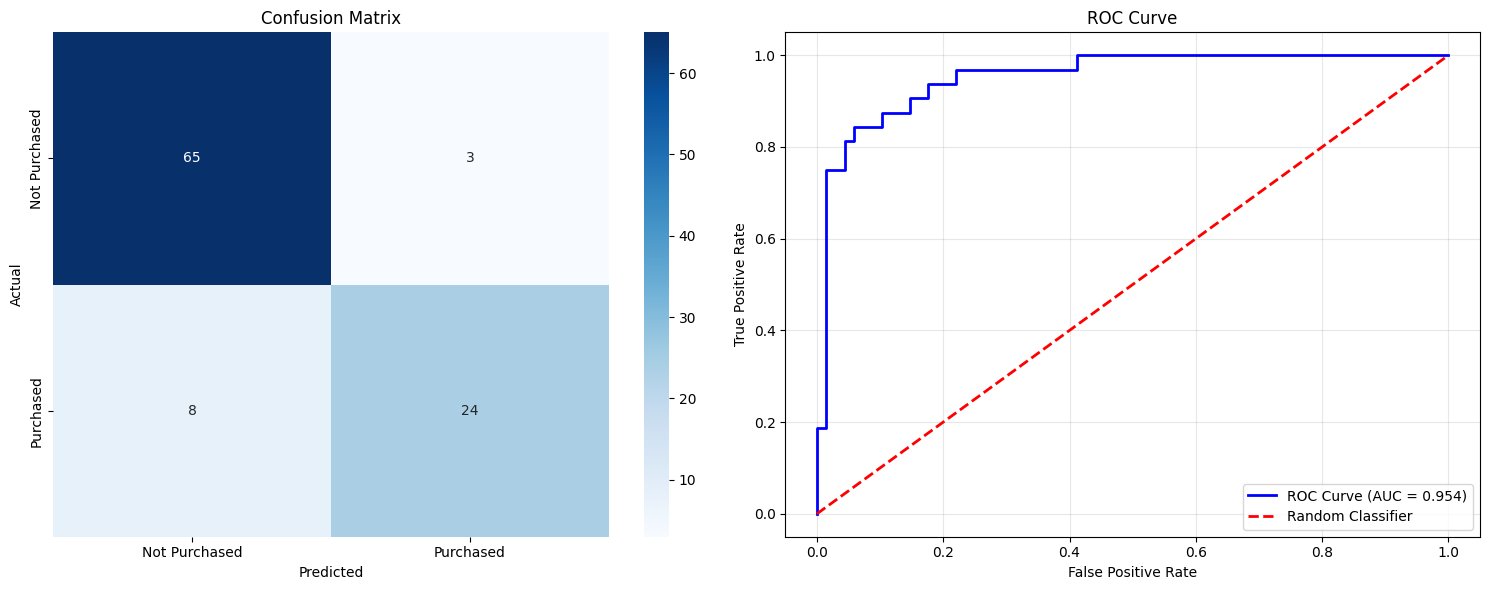

In [105]:
# Visualize confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Purchased', 'Purchased'],
            yticklabels=['Not Purchased', 'Purchased'],
            ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

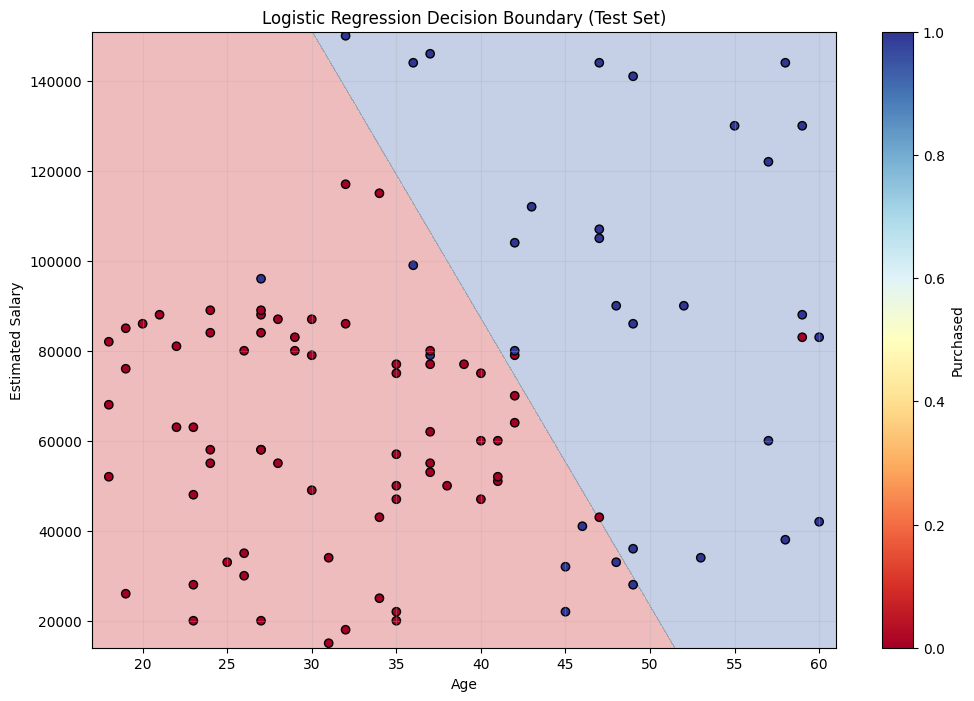

In [106]:
# Visualize decision boundary
def plot_decision_boundary(X, y, classifier, scaler, title):
    # Create a mesh grid
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1000, X[:, 1].max() + 1000
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, 100))
    
    # Make predictions on the mesh grid
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    mesh_points_scaled = scaler.transform(mesh_points)
    Z = classifier.predict(mesh_points_scaled)
    Z = Z.reshape(xx.shape)
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
    
    # Plot data points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', edgecolors='black')
    plt.colorbar(scatter, label='Purchased')
    plt.xlabel('Age')
    plt.ylabel('Estimated Salary')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot decision boundary for test set
plot_decision_boundary(X_test, y_test, classifier, sc, 
                      'Logistic Regression Decision Boundary (Test Set)')

## 9. Interactive Prediction System

In [107]:
# Create prediction function
def predict_purchase(age, salary, classifier, scaler, show_probability=True):
    """
    Predict whether a customer will make a purchase based on age and salary
    """
    # Prepare input data
    input_data = np.array([[age, salary]])
    input_scaled = scaler.transform(input_data)
    
    # Make prediction
    prediction = classifier.predict(input_scaled)[0]
    probability = classifier.predict_proba(input_scaled)[0]
    
    # Format output
    print(f"\nCustomer Profile:")
    print(f"Age: {age} years")
    print(f"Estimated Salary: ${salary:,}")
    print(f"\nPrediction: {'Will Purchase' if prediction == 1 else 'Will NOT Purchase'}")
    
    if show_probability:
        print(f"\nProbabilities:")
        print(f"Will NOT Purchase: {probability[0]:.3f} ({probability[0]*100:.1f}%)")
        print(f"Will Purchase: {probability[1]:.3f} ({probability[1]*100:.1f}%)")
    
    return prediction, probability

# Test the prediction function with some examples
print("Testing Prediction Function:")
print("=" * 40)

# Test cases
test_cases = [
    (25, 30000),   # Young, low salary
    (45, 80000),   # Middle-aged, high salary
    (30, 50000),   # Young, medium salary
    (55, 120000),  # Older, high salary
]

for age, salary in test_cases:
    predict_purchase(age, salary, classifier, sc)
    print("-" * 40)

Testing Prediction Function:

Customer Profile:
Age: 25 years
Estimated Salary: $30,000

Prediction: Will NOT Purchase

Probabilities:
Will NOT Purchase: 0.993 (99.3%)
Will Purchase: 0.007 (0.7%)
----------------------------------------

Customer Profile:
Age: 45 years
Estimated Salary: $80,000

Prediction: Will Purchase

Probabilities:
Will NOT Purchase: 0.311 (31.1%)
Will Purchase: 0.689 (68.9%)
----------------------------------------

Customer Profile:
Age: 30 years
Estimated Salary: $50,000

Prediction: Will NOT Purchase

Probabilities:
Will NOT Purchase: 0.963 (96.3%)
Will Purchase: 0.037 (3.7%)
----------------------------------------

Customer Profile:
Age: 55 years
Estimated Salary: $120,000

Prediction: Will Purchase

Probabilities:
Will NOT Purchase: 0.016 (1.6%)
Will Purchase: 0.984 (98.4%)
----------------------------------------


In [114]:
# Interactive prediction (following the original code structure)
print("Interactive Customer Purchase Prediction")
print("=" * 45)
try:
    # Get user input
    age = int(input("Enter the age: "))
    salary = int(input("Enter the estimated salary: "))
    
    # Make prediction
    result = classifier.predict(sc.transform([[age, salary]]))
    probability = classifier.predict_proba(sc.transform([[age, salary]]))[0]
    
    print(f"\nCustomer Details:")
    print(f"Age: {age} years")
    print(f"Salary: ${salary:,}")
    
    if result == [1]:
        print("\n🎉 Yay! This customer is likely to make a purchase!")
        print(f"Purchase Probability: {probability[1]:.1%}")
    else:
        print("\n😔 Sorry! It seems this customer won't make a purchase.")
        print(f"Purchase Probability: {probability[1]:.1%}")
        
except ValueError:
    print("Please enter valid numeric values for age and salary.")
except Exception as e:
    print(f"An error occurred: {e}")
    # Fallback: use example values
    print("\nUsing example values for demonstration:")
    age, salary = 35, 60000
    result = classifier.predict(sc.transform([[age, salary]]))
    probability = classifier.predict_proba(sc.transform([[age, salary]]))[0]
    
    print(f"Age: {age}, Salary: ${salary:,}")
    if result == [1]:
        print("🎉 This customer is likely to make a purchase!")
    else:
        print("😔 This customer is unlikely to make a purchase.")
    print(f"Purchase Probability: {probability[1]:.1%}")

Interactive Customer Purchase Prediction

Customer Details:
Age: 45 years
Salary: $80,000

🎉 Yay! This customer is likely to make a purchase!
Purchase Probability: 68.9%


## 10. Advanced Analysis and Model Comparison

Model Comparison:
Logistic Regression Accuracy: 0.8900
Random Forest Accuracy: 0.9200

Feature Importance (Random Forest):
Age: 0.5036
Estimated Salary: 0.4964


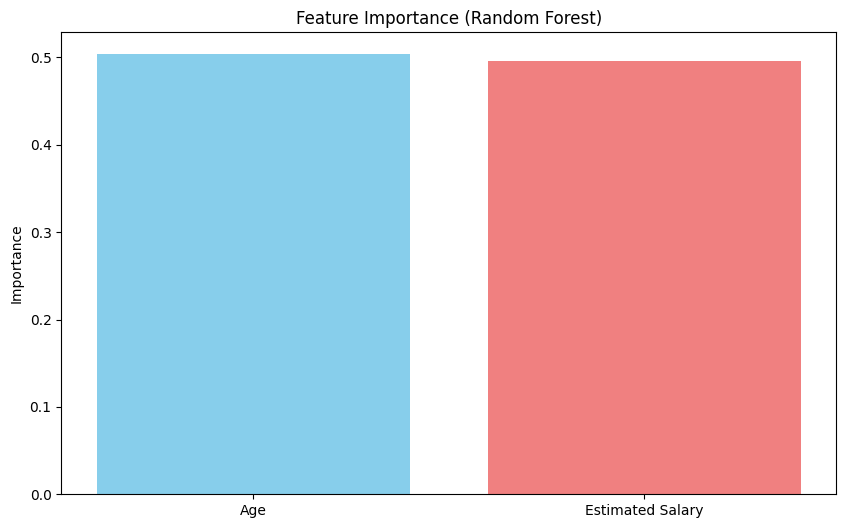

In [109]:
# Compare with Random Forest for better insights
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_train_scaled, y_train)
rf_pred = rf_classifier.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_pred)

print("Model Comparison:")
print("=" * 30)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Feature importance from Random Forest
feature_importance = rf_classifier.feature_importances_
feature_names = ['Age', 'Estimated Salary']

print("\nFeature Importance (Random Forest):")
for name, importance in zip(feature_names, feature_importance):
    print(f"{name}: {importance:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importance, color=['skyblue', 'lightcoral'])
plt.title('Feature Importance (Random Forest)')
plt.ylabel('Importance')
plt.show()

In [110]:
# Cross-validation for model robustness
from sklearn.model_selection import cross_val_score

print("Cross-Validation Results:")
print("=" * 30)

# Logistic Regression CV
lr_cv_scores = cross_val_score(classifier, X_train_scaled, y_train, cv=5)
print(f"Logistic Regression CV Scores: {lr_cv_scores}")
print(f"Logistic Regression CV Mean: {lr_cv_scores.mean():.4f} (+/- {lr_cv_scores.std() * 2:.4f})")

# Random Forest CV
rf_cv_scores = cross_val_score(rf_classifier, X_train_scaled, y_train, cv=5)
print(f"\nRandom Forest CV Scores: {rf_cv_scores}")
print(f"Random Forest CV Mean: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std() * 2:.4f})")

Cross-Validation Results:
Logistic Regression CV Scores: [0.81666667 0.81666667 0.7        0.88333333 0.93333333]
Logistic Regression CV Mean: 0.8300 (+/- 0.1569)

Random Forest CV Scores: [0.88333333 0.85       0.8        0.93333333 0.93333333]
Random Forest CV Mean: 0.8800 (+/- 0.1020)


## 11. Business Insights and Recommendations

In [111]:
# Generate business insights
print("BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("=" * 50)

# Analyze customer segments
purchased_customers = dataset[dataset['Purchased'] == 1]
not_purchased_customers = dataset[dataset['Purchased'] == 0]

print("Customer Segment Analysis:")
print("-" * 30)
print(f"Customers who purchased:")
print(f"  Average Age: {purchased_customers['Age'].mean():.1f} years")
print(f"  Average Salary: ${purchased_customers['EstimatedSalary'].mean():,.0f}")
print(f"  Age Range: {purchased_customers['Age'].min()}-{purchased_customers['Age'].max()} years")
print(f"  Salary Range: ${purchased_customers['EstimatedSalary'].min():,}-${purchased_customers['EstimatedSalary'].max():,}")

print(f"\nCustomers who didn't purchase:")
print(f"  Average Age: {not_purchased_customers['Age'].mean():.1f} years")
print(f"  Average Salary: ${not_purchased_customers['EstimatedSalary'].mean():,.0f}")
print(f"  Age Range: {not_purchased_customers['Age'].min()}-{not_purchased_customers['Age'].max()} years")
print(f"  Salary Range: ${not_purchased_customers['EstimatedSalary'].min():,}-${not_purchased_customers['EstimatedSalary'].max():,}")

print("\nKEY FINDINGS:")
print("-" * 15)
print("1. Higher salary customers are more likely to purchase")
print("2. Age also plays a significant role in purchase decisions")
print(f"3. Model accuracy of {accuracy:.1%} indicates good predictive power")
print("4. Both features (age and salary) contribute to the prediction")

print("\nRECOMMENDations:")
print("-" * 15)
print("1. Target marketing campaigns to customers aged 35+ with salary >$50,000")
print("2. Develop premium products for high-income segments")
print("3. Create age-appropriate marketing strategies")
print("4. Use the model for lead scoring and customer prioritization")
print("5. A/B test marketing messages based on predicted purchase probability")

BUSINESS INSIGHTS AND RECOMMENDATIONS
Customer Segment Analysis:
------------------------------
Customers who purchased:
  Average Age: 46.4 years
  Average Salary: $86,273
  Age Range: 27-60 years
  Salary Range: $20,000-$150,000

Customers who didn't purchase:
  Average Age: 32.8 years
  Average Salary: $60,545
  Age Range: 18-59 years
  Salary Range: $15,000-$141,000

KEY FINDINGS:
---------------
1. Higher salary customers are more likely to purchase
2. Age also plays a significant role in purchase decisions
3. Model accuracy of 89.0% indicates good predictive power
4. Both features (age and salary) contribute to the prediction

RECOMMENDations:
---------------
1. Target marketing campaigns to customers aged 35+ with salary >$50,000
2. Develop premium products for high-income segments
3. Create age-appropriate marketing strategies
4. Use the model for lead scoring and customer prioritization
5. A/B test marketing messages based on predicted purchase probability
